In [475]:
%load_ext autoreload
%autoreload 2
import torch
import sys
sys.path.insert(0, '/home/akiva/FCNX-Ensembling/lib')

from FCN3Network import FCN3NetworkEnsembleErf
from Experiment import Experiment

experimentMF = Experiment(
        eps=0.03,
        file = '/home/akiva/exp/fcn3erf/erf_cubic_eps_0.03_P_250_D_40_N_400_epochs_25000000_lrA_1.33e-06_time_20251118_155401',
        N=400,
        d=40,
        chi=50,
        P=250,
        ens=3,
        device = torch.device('cuda:1')
    )
experimentMF.load()
experimentMF.model.to(experimentMF.device)
X, Y1,Y3 = experimentMF.large_dataset(p_large = 3000, flat=True)
experimentMF.model.device = experimentMF.device
# compute the svd of the low rank approximaton to H
# Random svd goes from H ∈ ℝ^m*m to its low rank approximation QB ∈ ℝ^m*m with Q ∈ ℝ^m*l and B ∈ ℝ^l*k. 
Q, Z = experimentMF.model.H_random_QB(X, k = 1600, p=10)
Ut, _S, V = torch.linalg.svd(Z.T)
m, n = Z.shape[1], Z.shape[0]
k = min(m, n)
Sigma = torch.zeros(m, n, device=Z.device, dtype=Z.dtype)
Sigma[:k, :k] = torch.diag(_S) 
U = torch.matmul(Q, Ut)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loaded model state_dict from /home/akiva/exp/fcn3erf/erf_cubic_eps_0.03_P_250_D_40_N_400_epochs_25000000_lrA_1.33e-06_time_20251118_155401/model.pth
[Random Omega generation] 0.0000s
[  res chunk [0:3000]] 0.0004s
[res computation (chunks of 4096)] 0.0004s
[QR factorisation] 0.0013s
[  Z chunk [0:3000]] 0.0002s
[Z computation (chunks of 4096)] 0.0003s


This is an implementation of diagonalization of the first k eigenvalues 

In [473]:
X, Y1,Y3 = experimentMF.large_dataset(p_large = 3000, flat=True)
experimentMF.model.device = experimentMF.device
# compute the svd of the low rank approximaton to H
# Random svd goes from H ∈ ℝ^m*m to its low rank approximation QB ∈ ℝ^m*m with Q ∈ ℝ^m*l and B ∈ ℝ^l*k. 
Q, Z = experimentMF.model.H_random_QB(X, k = 1600, p=10)
Ut, _S, V = torch.linalg.svd(Z.T)
m, n = Z.shape[1], Z.shape[0]
k = min(m, n)
Sigma = torch.zeros(m, n, device=Z.device, dtype=Z.dtype)
Sigma[:k, :k] = torch.diag(_S) 
U = torch.matmul(Q, Ut)


[Random Omega generation] 0.0000s
[  res chunk [0:3000]] 0.0006s
[res computation (chunks of 4096)] 0.0006s
[QR factorisation] 0.0022s
[  Z chunk [0:3000]] 0.0002s
[Z computation (chunks of 4096)] 0.0004s


In [474]:
Sigma[0] / X.shape[0]

tensor([0.0658, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000], device='cuda:1')

In [461]:
experimentMF.model.H_eig(X, Y)

tensor([0.0647, 0.0101, 0.0101, 0.0098, 0.0102, 0.0105, 0.0101, 0.0096, 0.0118,
        0.0102, 0.0107, 0.0094, 0.0102, 0.0106, 0.0095, 0.0094, 0.0092, 0.0106,
        0.0105, 0.0101, 0.0101, 0.0101, 0.0111, 0.0108, 0.0108, 0.0099, 0.0086,
        0.0100, 0.0095, 0.0091, 0.0101, 0.0101, 0.0098, 0.0093, 0.0095, 0.0099,
        0.0093, 0.0099, 0.0105, 0.0111], device='cuda:1')

In [462]:
pred = experimentMF.eig_predictions()
pred

Eigenvalues(lJ1T=0.010567832742807797, lJ3T=4.368062123311861e-05, lH1T=0.045003022379059385, lH3T=4.3689386580946455e-05, lJ1P=0.010610329539460598, lJ3P=4.42097064144154e-05, lH1P=0.010610329539460598, lH3P=4.42097064144154e-05)

In [465]:
print(f'lH3T Prediction: {pred.lH3T: .8f}')
print(f'lH3P Prediction: {pred.lH3P: .8f}')

lH3T Prediction:  0.00004369
lH3P Prediction:  0.00004421


In [467]:
import torch

Y = Y3 / torch.norm(Y1, dim=0)
Yp = torch.matmul(Y.t(), U)
left_eigenvalues = (Yp @ Sigma @ torch.matmul(V, Y)).diagonal() / X.shape[0] 

# Ensure tensors are on CPU and converted to numpy
S = Sigma.diagonal().detach().cpu().numpy()[:] / X.shape[0]
left_eig = left_eigenvalues.detach().cpu().numpy() 

# Sort both in descending order
S_sorted = np.sort(S)[::-1]
left_eig_sorted = np.sort(left_eig)[::-1]

print("=== Sigma diagonal (sorted descending, 5 sig figs) ===")
for i, val in enumerate(S_sorted, 1):
    print(f"{i:3d}: {val:.6f}")

print("\n=== Left eigenvalues (sorted descending, 5 sig figs) ===")
for i, val in enumerate(left_eig_sorted, 1):
    print(f"{i:3d}: {val:.6f}")

=== Sigma diagonal (sorted descending, 5 sig figs) ===
  1: 0.065839
  2: 0.015939
  3: 0.015488
  4: 0.014919
  5: 0.014611
  6: 0.013799
  7: 0.013505
  8: 0.013115
  9: 0.012572
 10: 0.012461
 11: 0.012097
 12: 0.011821
 13: 0.011685
 14: 0.011520
 15: 0.010981
 16: 0.010864
 17: 0.010584
 18: 0.010328
 19: 0.010199
 20: 0.009797
 21: 0.009688
 22: 0.009378
 23: 0.009258
 24: 0.008986
 25: 0.008764
 26: 0.008529
 27: 0.008331
 28: 0.008272
 29: 0.007932
 30: 0.007747
 31: 0.007692
 32: 0.007580
 33: 0.007263
 34: 0.007114
 35: 0.006978
 36: 0.006647
 37: 0.006543
 38: 0.006253
 39: 0.005736
 40: 0.005299
 41: 0.000176
 42: 0.000168
 43: 0.000167
 44: 0.000165
 45: 0.000163
 46: 0.000160
 47: 0.000159
 48: 0.000159
 49: 0.000156
 50: 0.000154
 51: 0.000154
 52: 0.000153
 53: 0.000152
 54: 0.000150
 55: 0.000149
 56: 0.000148
 57: 0.000147
 58: 0.000146
 59: 0.000146
 60: 0.000143
 61: 0.000142
 62: 0.000141
 63: 0.000141
 64: 0.000140
 65: 0.000139
 66: 0.000138
 67: 0.000137
 68: 0.

In [ ]:
plt.plot

tensor([1.0557e-04, 9.6688e-05, 8.4316e-05, 7.4329e-05, 7.3307e-05, 6.4706e-05,
        6.4624e-05, 6.2550e-05, 6.0416e-05, 5.7226e-05, 5.5458e-05, 5.5281e-05,
        5.1410e-05, 5.0176e-05, 4.9724e-05, 4.9123e-05, 4.9099e-05, 4.9084e-05,
        4.7658e-05, 4.5451e-05, 4.5077e-05, 4.5062e-05, 4.4388e-05, 4.4095e-05,
        4.4095e-05, 4.4042e-05, 4.2493e-05, 4.1647e-05, 4.1428e-05, 3.9379e-05,
        3.8645e-05, 3.8079e-05, 3.6438e-05, 3.6108e-05, 3.5402e-05, 3.5225e-05,
        3.4292e-05, 3.2940e-05, 3.2317e-05, 2.9912e-05], device='cuda:1')

In [417]:
Sigma.diagonal()[:40].shape

torch.Size([40])

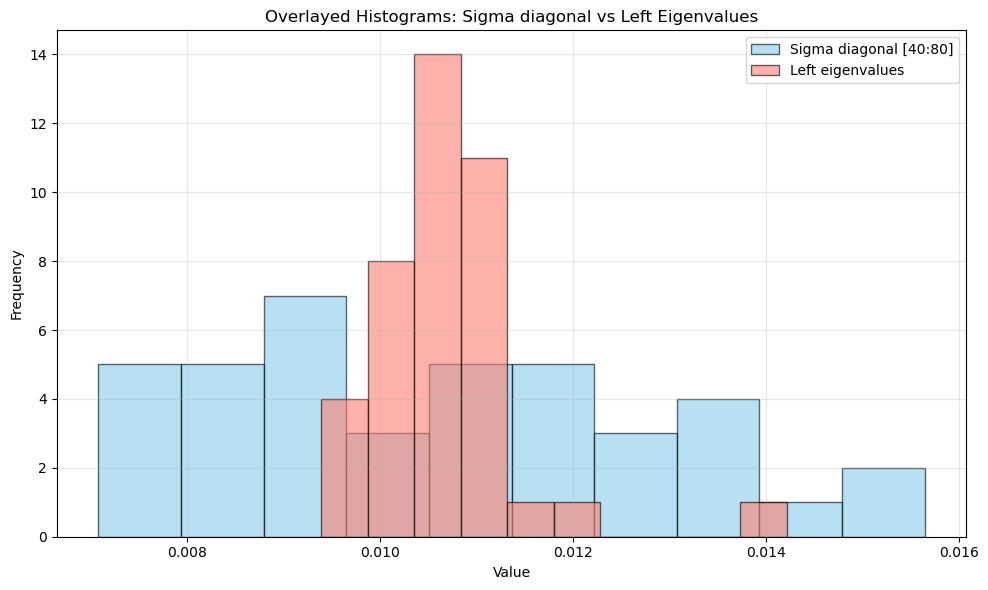

In [422]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

# First histogram (Sigma diagonal)
plt.hist(Sigma.diagonal()[:40].detach().cpu().numpy() / X.shape[0],
        #  density=True,
         bins=10,
         alpha=0.6,
         label='Sigma diagonal [40:80]',
         color='skyblue',
         edgecolor='black')

# Second histogram (left eigenvalues) - overlaid
plt.hist(left_eigenvalues.detach().cpu().numpy(),
        #  density=True,
         bins=10,
         alpha=0.6,
         label='Left eigenvalues',
         color='salmon',
         edgecolor='black')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Overlayed Histograms: Sigma diagonal vs Left Eigenvalues')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

tensor([6.4616e-05, 6.4236e-05, 6.2796e-05, 6.2253e-05, 6.1882e-05, 6.1307e-05,
        6.0629e-05, 6.0136e-05, 5.9791e-05, 5.9311e-05, 5.8777e-05, 5.8702e-05,
        5.7932e-05, 5.7524e-05, 5.7364e-05, 5.6931e-05, 5.6433e-05, 5.5989e-05,
        5.5511e-05, 5.5293e-05, 5.5018e-05, 5.4827e-05, 5.4374e-05, 5.4094e-05,
        5.3860e-05, 5.3632e-05, 5.3427e-05, 5.2696e-05, 5.2614e-05, 5.2549e-05,
        5.2009e-05, 5.1747e-05, 5.1298e-05, 5.1219e-05, 5.0753e-05, 5.0470e-05,
        5.0172e-05, 4.9955e-05, 4.9635e-05, 4.9593e-05], device='cuda:1')

In [315]:
model.H_eig(X, Y3)

tensor([0.0003, 0.0003, 0.0005, 0.0006, 0.0006, 0.0004, 0.0004, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0004, 0.0005, 0.0004, 0.0006, 0.0006, 0.0005, 0.0004,
        0.0005, 0.0005, 0.0005, 0.0006, 0.0004, 0.0009, 0.0004, 0.0005, 0.0006,
        0.0006, 0.0006, 0.0006, 0.0004, 0.0006, 0.0007, 0.0007, 0.0009, 0.0004,
        0.0015, 0.0007, 0.0006, 0.0004], device='cuda:1')

tensor([0.0143, 0.0108, 0.0098, 0.0105, 0.0103, 0.0105, 0.0095, 0.0114, 0.0110,
        0.0111, 0.0109, 0.0110, 0.0100, 0.0113, 0.0111, 0.0109, 0.0111, 0.0105,
        0.0109, 0.0110, 0.0113, 0.0113, 0.0106, 0.0106, 0.0114, 0.0102, 0.0110,
        0.0111, 0.0120, 0.0095, 0.0106, 0.0109, 0.0123, 0.0112, 0.0123, 0.0096,
        0.0098, 0.0117, 0.0102, 0.0111], device='cuda:1')

OutOfMemoryError: CUDA out of memory. Tried to allocate 7.45 GiB. GPU 1 has a total capacity of 15.70 GiB of which 1.14 GiB is free. Process 1631201 has 420.00 MiB memory in use. Process 1122074 has 390.00 MiB memory in use. Process 1122191 has 716.00 MiB memory in use. Process 1123384 has 448.00 MiB memory in use. Process 1124719 has 560.00 MiB memory in use. Process 1124829 has 910.00 MiB memory in use. Process 1127468 has 422.00 MiB memory in use. Process 1127625 has 916.00 MiB memory in use. Including non-PyTorch memory, this process has 9.83 GiB memory in use. Of the allocated memory 2.22 GiB is allocated by PyTorch, and 7.30 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [297]:
Sigma.diagonal()[:40]

tensor([0.0166, 0.0158, 0.0153, 0.0152, 0.0145, 0.0142, 0.0138, 0.0134, 0.0130,
        0.0129, 0.0127, 0.0120, 0.0119, 0.0118, 0.0116, 0.0112, 0.0111, 0.0109,
        0.0108, 0.0105, 0.0103, 0.0099, 0.0097, 0.0096, 0.0095, 0.0091, 0.0090,
        0.0089, 0.0086, 0.0085, 0.0081, 0.0078, 0.0075, 0.0075, 0.0074, 0.0071,
        0.0071, 0.0068, 0.0067, 0.0064], device='cuda:1')

## Diagnostics of Random SVD Projections

The theory predicts sandwich values and not exact eigenvalues. We want to establish 

[Random Omega generation] 0.0000s
[  res chunk [0:1000]] 0.0004s
[res computation (chunks of 4096)] 0.0005s
[QR factorisation] 0.0002s
[  Z chunk [0:1000]] 0.0001s
[Z computation (chunks of 4096)] 0.0002s
rank=  40 → MSE = 1.21e+02
[Random Omega generation] 0.0001s
[  res chunk [0:1000]] 0.0003s
[res computation (chunks of 4096)] 0.0004s
[QR factorisation] 0.0002s
[  Z chunk [0:1000]] 0.0002s
[Z computation (chunks of 4096)] 0.0003s
rank=  41 → MSE = 1.21e+02
[Random Omega generation] 0.0000s
[  res chunk [0:1000]] 0.0003s
[res computation (chunks of 4096)] 0.0004s
[QR factorisation] 0.0002s
[  Z chunk [0:1000]] 0.0001s
[Z computation (chunks of 4096)] 0.0002s
rank=  42 → MSE = 1.21e+02
[Random Omega generation] 0.0000s
[  res chunk [0:1000]] 0.0003s
[res computation (chunks of 4096)] 0.0004s
[QR factorisation] 0.0002s
[  Z chunk [0:1000]] 0.0002s
[Z computation (chunks of 4096)] 0.0002s
rank=  43 → MSE = 1.21e+02
[Random Omega generation] 0.0000s
[  res chunk [0:1000]] 0.0005s
[res co

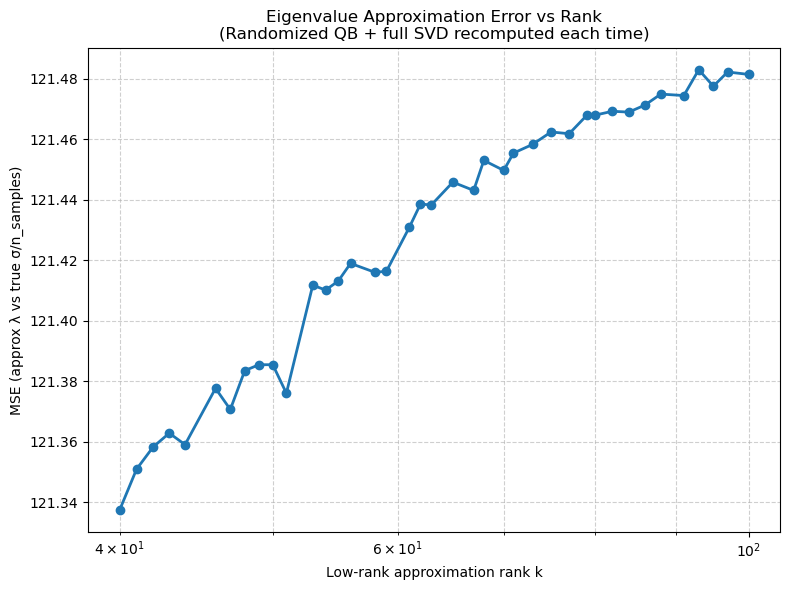

In [239]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 1. Exact method you wanted: rectangular diagonal matrix from S
# ------------------------------------------------------------------
def to_rectangular_sigma(S, m, n=None, device=None):
    """
    Convert 1D singular values `S` (from torch.linalg.svd) 
    into the proper rectangular (m × n) diagonal matrix Σ.
    """
    if n is None:
        n = m
    k = len(S)
    device = device or S.device
    Sigma = torch.zeros(m, n, device=device, dtype=S.dtype)
    Sigma[:k, :k] = torch.diag(S)
    return Sigma

# ------------------------------------------------------------------
# 2. The experiment — recomputes SVD every iteration, as requested
# ------------------------------------------------------------------
def plot_lowrank_eigenvalue_residual_vs_rank(X, Y1, model, max_k=100):
    device = X.device
    n_samples = X.shape[0]
    
    # Log-spaced ranks from 1 to max_k
    ranks = np.unique(np.logspace(np.log10(40), np.log10(max_k), 40, dtype=int))
    ranks = ranks[ranks >= 1]
    
    residuals = []
    
    for rank in ranks:
        # Recompute random QB approximation with current rank
        Q, Z = model.H_random_QB(X, k=rank)          # Z is (rank × m)
        
        # Full SVD of Z.T  →  Z.T is (m × rank)
        Ut, S, V = torch.linalg.svd(Z.T, full_matrices=False)
        
        m_dim = Z.shape[1]      # actual data dimension
        Sigma = to_rectangular_sigma(S, m=m_dim, n=m_dim, device=device)
        Sigma = Sigma / n_samples                       # as in your code
        
        # Left singular vectors in original space
        U = Q @ Ut                                      # (m × rank)
        
        # Project Y1 onto these directions
        Y1p = Y1.t() @ U                                # (n_samples × rank)
        
        # Compute your "left eigenvalues"
        left_eigenvalues = (Y1p @ Sigma @ (V @ Y1)).diagonal() 
        
        # True scaled singular values (only first `rank` exist)
        true_singular_scaled = S / n_samples
        
        # MSE between approximated eigenvalues and true scaled singular values
        mse = ((left_eigenvalues - true_singular_scaled[:left_eigenvalues.shape[0]]) ** 2).mean().item()
        residuals.append(mse)
        
        print(f"rank={rank:4d} → MSE = {mse:.2e}")
    
    # ------------------------------------------------------------------
    # 3. Plot
    # ------------------------------------------------------------------
    plt.figure(figsize=(8, 6))
    plt.semilogx(ranks, residuals, 'o-', linewidth=2, markersize=6)
    plt.xlabel('Low-rank approximation rank k')
    plt.ylabel('MSE (approx λ vs true σ/n_samples)')
    plt.title('Eigenvalue Approximation Error vs Rank\n'
              '(Randomized QB + full SVD recomputed each time)')
    plt.grid(True, which='both', ls='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    
    return ranks, residuals

# ------------------------------------------------------------------
# Run it (your original data loading)
# ------------------------------------------------------------------
X, Y1, Y3 = experimentMF.large_dataset(p_large=1000, flat=True)
experimentMF.model.device = experimentMF.device

ranks, residuals = plot_lowrank_eigenvalue_residual_vs_rank(
    X=X, Y1=Y1, model=experimentMF.model, max_k=100
)

[Random Omega generation] 0.0001s
[  res chunk [0:1000]] 0.0005s
[res computation (chunks of 4096)] 0.0006s
[QR factorisation] 0.0002s
[  Z chunk [0:1000]] 0.0003s
[Z computation (chunks of 4096)] 0.0004s
rank=  40 → MSE = 9.61e-06
[Random Omega generation] 0.0000s
[  res chunk [0:1000]] 0.0003s
[res computation (chunks of 4096)] 0.0004s
[QR factorisation] 0.0002s
[  Z chunk [0:1000]] 0.0001s
[Z computation (chunks of 4096)] 0.0002s
rank=  44 → MSE = 9.60e-06
[Random Omega generation] 0.0000s
[  res chunk [0:1000]] 0.0003s
[res computation (chunks of 4096)] 0.0004s
[QR factorisation] 0.0003s
[  Z chunk [0:1000]] 0.0002s
[Z computation (chunks of 4096)] 0.0002s
rank=  49 → MSE = 9.60e-06
[Random Omega generation] 0.0000s
[  res chunk [0:1000]] 0.0003s
[res computation (chunks of 4096)] 0.0004s
[QR factorisation] 0.0002s
[  Z chunk [0:1000]] 0.0001s
[Z computation (chunks of 4096)] 0.0002s
rank=  54 → MSE = 9.60e-06
[Random Omega generation] 0.0000s
[  res chunk [0:1000]] 0.0003s
[res co

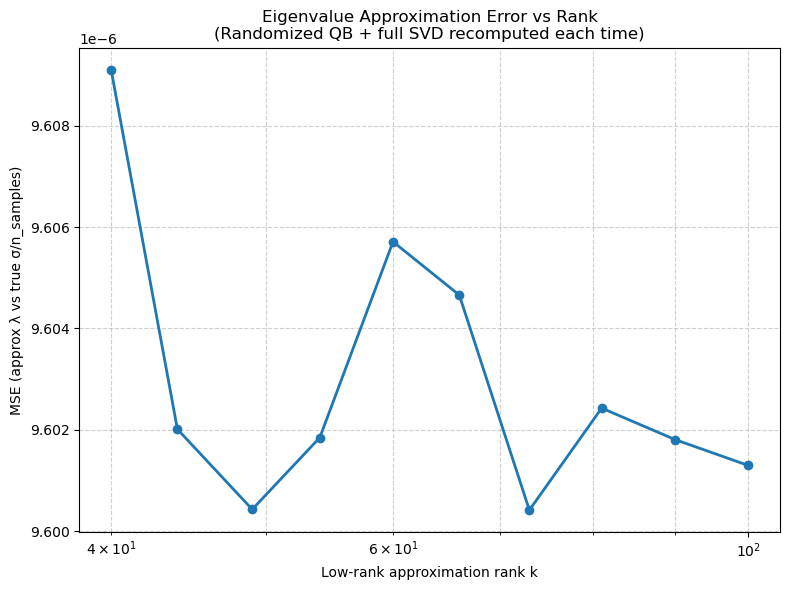

In [271]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 1. Exact method you wanted: rectangular diagonal matrix from S
# ------------------------------------------------------------------
def to_rectangular_sigma(S, m, n=None, device=None):
    """
    Convert 1D singular values `S` (from torch.linalg.svd) 
    into the proper rectangular (m × n) diagonal matrix Σ.
    """
    if n is None:
        n = m
    k = len(S)
    device = device or S.device
    Sigma = torch.zeros(m, n, device=device, dtype=S.dtype)
    Sigma[:k, :k] = torch.diag(S)
    return Sigma


# ------------------------------------------------------------------
# 2. The experiment — recomputes SVD every iteration, as requested
# ------------------------------------------------------------------
def plot_lowrank_eigenvalue_residual_vs_rank(X, Y, model, max_k=100):
    device = X.device
    n_samples = X.shape[0]
    
    # Log-spaced ranks from 1 to max_k
    ranks = np.unique(np.logspace(np.log10(40), np.log10(max_k), 10, dtype=int))
    ranks = ranks[ranks >= 1]
    
    residuals = []
    singular_values = []
    sandwiches = []
    for rank in ranks:
        # Recompute random QB approximation with current rank
        Q, Z = experimentMF.model.H_random_QB(X, k = rank)
        Ut, _S, V = torch.linalg.svd(Z.T)
        m, n = Z.shape[1], Z.shape[0]
        k = min(m, n)
        Sigma = torch.zeros(m, n, device=Z.device, dtype=Z.dtype)
        Sigma[:k, :k] = torch.diag(_S) / X.shape[0]
        U = torch.matmul(Q, Ut)
        Y1p = torch.matmul(Y1.t(), U)
        left_eigenvalues = (Y1p @ Sigma @ torch.matmul(V, Y1)).diagonal() / X.shape[0]
        
        true_singular_scaled = _S / X.shape[0]
        sandwiches.append(left_eigenvalues.tolist())
        singular_values.append(true_singular_scaled[:left_eigenvalues.shape[0]].tolist())
        # MSE between approximated eigenvalues and true scaled singular values
        mse = ((left_eigenvalues - true_singular_scaled[:left_eigenvalues.shape[0]]) ** 2).mean().item()
        residuals.append(mse)
        
        print(f"rank={rank:4d} → MSE = {mse:.2e}")
    
    # ------------------------------------------------------------------
    # 3. Plot
    # ------------------------------------------------------------------
    plt.figure(figsize=(8, 6))
    plt.semilogx(ranks, residuals, 'o-', linewidth=2, markersize=6)
    plt.xlabel('Low-rank approximation rank k')
    plt.ylabel('MSE (approx λ vs true σ/n_samples)')
    plt.title('Eigenvalue Approximation Error vs Rank\n'
              '(Randomized QB + full SVD recomputed each time)')
    plt.grid(True, which='both', ls='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    
    return ranks, residuals, singular_values, sandwiches

# ------------------------------------------------------------------
# Run it (your original data loading)
# ------------------------------------------------------------------
X, Y1, Y3 = experimentMF.large_dataset(p_large=1000, flat=True)
experimentMF.model.device = experimentMF.device

ranks, residuals, singular_values, sandwiches = plot_lowrank_eigenvalue_residual_vs_rank(
    X=X, Y=Y3, model=experimentMF.model, max_k=100
)




In [270]:
sandwiches[-1]

[0.0014137904732591492,
 0.0014294261708258007,
 0.0022117944875425155,
 0.0039360206512769665,
 0.0026514386583026592,
 0.0022938092154930934,
 0.0016992038327716713,
 0.004772915792423655,
 0.002721382422431537,
 0.0037770146849966458,
 0.0021370177296159416,
 0.0033968014206587284,
 0.0023521305214759757,
 0.0018510161649259013,
 0.0024183671880034993,
 0.005058621171665508,
 0.0023514476614318824,
 0.0024119321978924068,
 0.0022184205772144004,
 0.0041304992721575675,
 0.0018519417156445453,
 0.0034420705597223394,
 0.0026140885183073685,
 0.0030777474003237603,
 0.0017965051309116302,
 0.0019571888615947256,
 0.004517264115723724,
 0.002310605253065466,
 0.00229763348400756,
 0.0031238082026574386,
 0.001849496865123391,
 0.0025670193222366053,
 0.007979361013317966,
 0.004372333554617285,
 0.009796161437103275,
 0.0019200856284845053,
 0.004075026783895781,
 0.0046498151448920305,
 0.0028373657327638896,
 0.002407900934434542]

/tmp/ipykernel_1160039/3757517523.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('viridis')


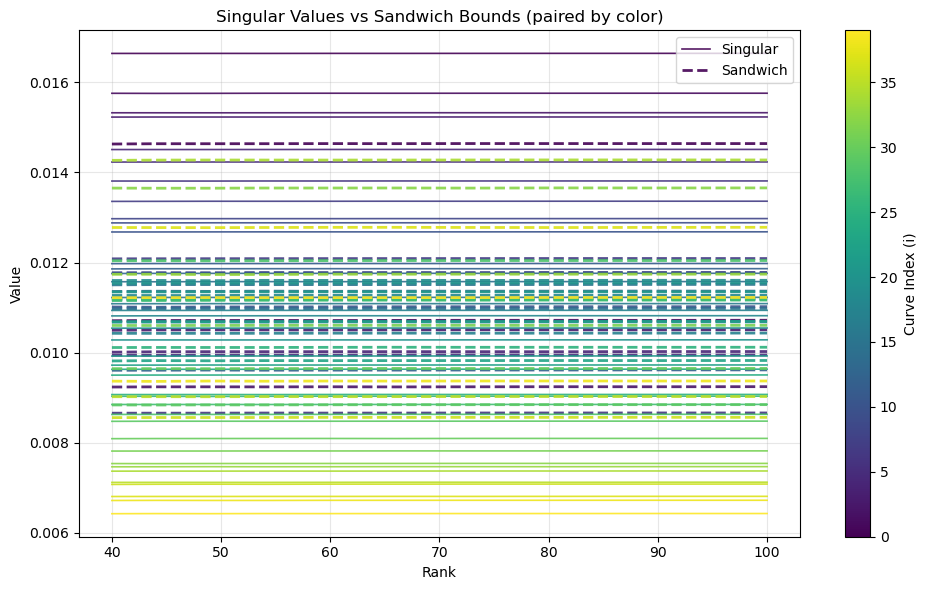

In [272]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import Normalize

plt.figure(figsize=(10, 6))

# Assume these are your data (replace with your actual variables)
# ranks: your common x-axis
# singular_values: shape (n_samples, N) → N lines
# sandwiches:      shape (n_samples, N) → N dashed lines (same N!)

# Transpose so we iterate over the N different curves
sv_curves = np.array(singular_values).T    # shape: (N, len(ranks))
sandwich_curves = np.array(sandwiches).T   # shape: (N, len(ranks))

N = sv_curves.shape[0]  # number of pairs

# Create a Viridis colormap and normalize index 0 to N-1
viridis = cm.get_cmap('viridis')
norm = Normalize(vmin=0, vmax=N-1)

for i in range(N):
    color = viridis(norm(i))  # same color for i-th singular and i-th sandwich

    # First group: thin solid lines
    plt.plot(ranks, sv_curves[i], 
             color=color, 
             linewidth=1.2,          # thin
             alpha=0.9,
             label='Singular' if i == 0 else None)  # only label once

    # Second group: dashed, same color, slightly thicker for visibility
    plt.plot(ranks, sandwich_curves[i], 
             color=color, 
             linestyle='--',
             linewidth=2.0, 
             alpha=0.9,
             label='Sandwich' if i == 0 else None)

plt.xlabel('Rank')
plt.ylabel('Value')
plt.title('Singular Values vs Sandwich Bounds (paired by color)')
plt.grid(True, alpha=0.3)

# Optional: add a single legend for the two styles
plt.legend()

# Optional: add a colorbar to show what the color means (index i)
sm = plt.cm.ScalarMappable(cmap=viridis, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('Curve Index (i)')

plt.tight_layout()
plt.show()